## Importing libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import glob as gb
import cv2

#For visualization
import matplotlib.pyplot as plt
%matplotlib inline

#For image preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


**os.listdir()** Method, Python method listdir() returns a list containing the names of the entries in the directory given by path

**glob** (short for global) is used to return all file paths that match a specific pattern.


In [ ]:
train_path = '/kaggle/input/cat-and-dog/training_set/training_set'
test_path = '../input/cat-and-dog/test_set/test_set'

printing number of images in each folder in the training set

In [ ]:
for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str( train_path +'//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

printing number of images in each folder in the test set

In [ ]:
for folder in  os.listdir(test_path) : 
    files = gb.glob(pathname= str( test_path +'//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

printing the of dimensions of the images in the training set

In [ ]:
size = []
for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str( train_path +'//' + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
        
pd.Series(size).value_counts()

printing the of dimensions of the images in the test set

In [ ]:
size = []
for folder in  os.listdir(test_path) : 
    files = gb.glob(pathname= str( test_path +'//' + folder + '/*.jpg'))
    for file in files: 
        image = plt.imread(file)
        size.append(image.shape)
pd.Series(size).value_counts()

In [ ]:
code = {'cats':0 ,'dogs':1}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x  

In [ ]:
X = []
y = []
for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str( train_path +'//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (64,64))
        X.append(list(image_array))
        y.append(code[folder])

In [ ]:
print(f'we have {len(X)} items in training set')

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X[i])   
    plt.axis('off')
    plt.title(getcode(y[i]))

## Data Preprocessing

### Preprocessing the Training set

**We will make some transformations to the images to avoid overfitting (Image augmentation)**

Data Augmentation is a technique of creating new data from existing data by applying some transformations such as flips, rotate at a various angle, shifts, zooms and many more. Training the neural network on more data leads to achieving higher accuracy. In real-world problem, we may have limited data. Therefore, data augmentation is often used to increase train dataset.

transformations such as:

- Translations
- Rotations
- Shearing
- Changes in scale
- Image fliping
- Zooming

**How Keras ImageDataGenerator Works**

- Take a batch of images used for training.
- Apply random transformations to each image in the batch.
- Replacing the original batch of images with a new randomly transformed batch.
- Train a Deep Learning model on this transformed batch.

rescale for scaling every pixel in the image (each pixel is between 0 to 255 so, the result will be between 0 and 1)




In [ ]:
#rescale for scaling every pixel in the image (each pixel is between 0 to 255 so, the result will be between 0 and 1)
#shear_range Shear angle in counter-clockwise direction in degrees
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

**Keras’ ImageDataGenerator** class provide three different functions to loads the image dataset in memory and generates batches of augmented data. These three functions are:

- .flow()

- .flow_from_directory()

- .flow_from_dataframe.()

**The flow_from_directory()** method takes a path of a directory and generates batches of augmented data it assumes:

- The root directory contains at least two folders one for train and one for the test.

- The train folder should contain n sub-directories each containing images of respective classes.

- The test folder should contain a single folder, which stores all test images.
 

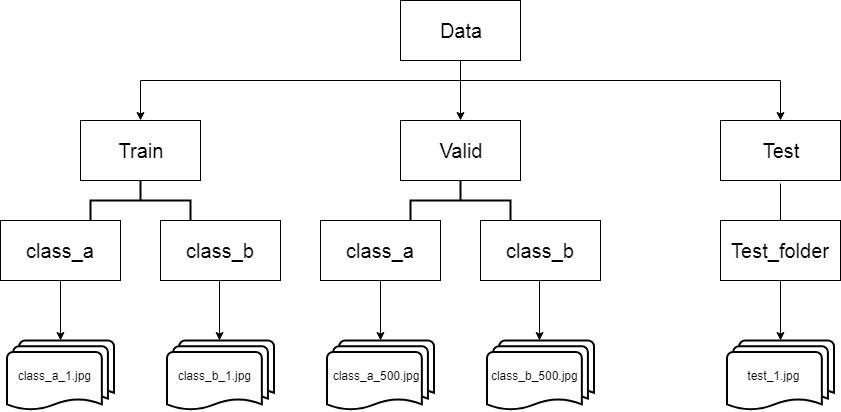

In [ ]:
#we will use train_datagen object to apply the transformation on tarining set
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

### Preprocessing the Test set

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

##  Building the CNN

**Initialising the CNN**

In [ ]:
cnn=tf.keras.models.Sequential()

**Step 1 - Convolution**

- we will put 32 feature detectors(kernels) with size 3*3
- we will use relu as activation function to increase the non linearity of the image
- The data contains 64*64 RGB images

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3, activation='relu',input_shape=[64,64,3]))

**Step 2 - Pooling**

This process is what provides the convolutional neural network with the "spatial variance" capability. In addition to that, pooling serves to minimize the size of the images as well as the number of parameters which, in turn, prevents an issue of "overfitting" from coming up.

In [ ]:
#pool_size=2 is the frame that will be applied in the feature map and takes the maximum number
#stides is the number of pixels the frame shifts to the right
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

**Adding a second convolutional layer**

In [ ]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3, activation='relu',input_shape=[64,64,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

**Step 3 - Flattening**

Flattening is used to convert all the resultant 2-Dimensional arrays from pooled feature maps into a single long continuous linear vector. 

In [ ]:
cnn.add(tf.keras.layers.Flatten())

**Step 4 - Full Connection**

Creating a fully connected layer

In [ ]:
#add is one the methods of Sequential class
#units is the number of neurons the hidden layer
#activation function of hidden layers is Relu
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))

**Step 5 - Output Layer**

In [ ]:
cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

## Training the CNN

We have to enter three parameters:

- The first one is the optimizer.

- Then the second one is to choose the loss function.

- And the third one is the metrics parameter because you can actually choose several metrics to evaluate your A and N at the same time
But we will only choose one and we will choose the accuracy.

In [ ]:
cnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

**Training the CNN on the Training set and evaluating it on the Test set**

In [ ]:
cnn.fit(x = training_set, validation_data = test_set, epochs=25)

## Making a single prediction

In [ ]:
test_image = tf.keras.utils.load_img('../input/cat-and-dog/test_set/test_set/dogs/dog.4003.jpg', target_size = (64, 64))
test_image

In [ ]:
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)


In [ ]:
result = cnn.predict(test_image/255.0)

if result[0][0] > 0.5:
    prediction = "dog"
else:
    prediction = "cat"
    
print(prediction)